In [1]:
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from sklearn.impute import KNNImputer
import xgboost

## PSS MLM

In [2]:
# Load the processed test dataset

test = pd.read_csv( "../data/processed/pss_test.csv",  index_col=0)

train = pd.read_csv( "../data/processed/pss_train.csv",  index_col=0)

# Split train  dataset into features (X) and target variable (y)
y_train = train['Is_shunt']
X_train = train.drop(['Is_shunt'], axis=1)

# Split test dataset into features (X) and target variable (y)
y_test = test['Is_shunt']
X_test = test.drop(['Is_shunt'], axis=1)



# define KNN imputer
imputer = KNNImputer()
# fit on the X_train
imputer.fit(X_train)
# transform the X_test
X_test_scaled = imputer.transform(X_test)



### XGBoost Model Evaluation with Unscaled Data

In [33]:
#Load the model
xgb = pickle.load(open('../trained_models/pss_model.pkl', 'rb'))


In [34]:
# Generate predictions
predictions = xgb.predict_proba(X_test)
y_pred = xgb.predict(X_test)

# Calculate False Positive Rate, and True Positive Rate with thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
# Calculate the Area Under the ROC Curve (AUC)
auc = roc_auc_score(y_test, predictions[:,1])

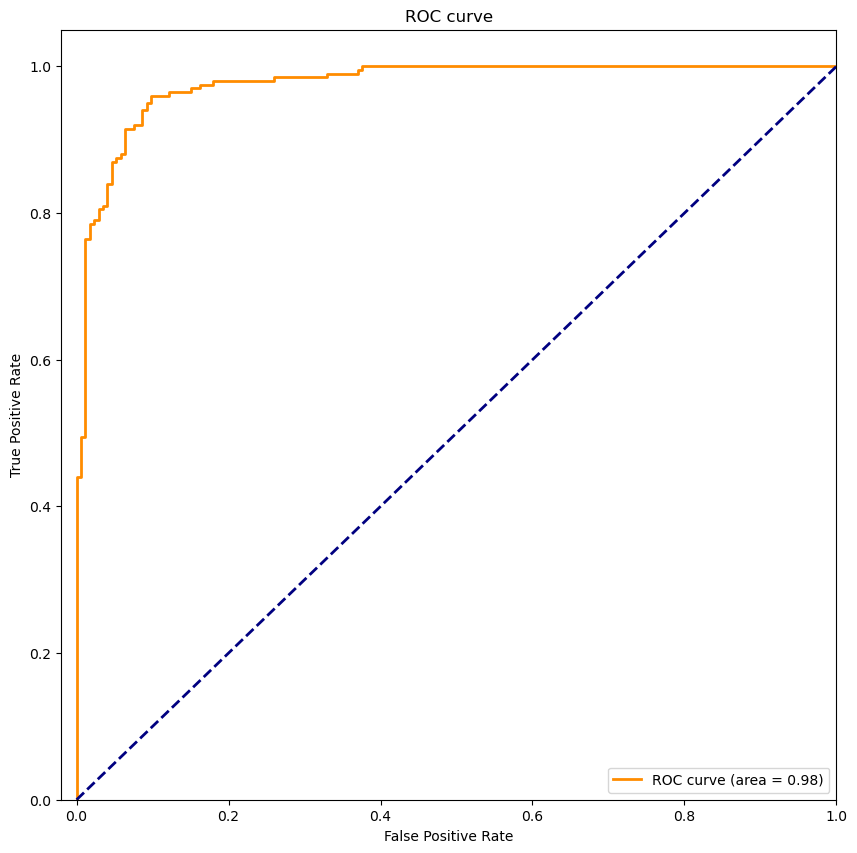

In [57]:
# Plot Area Under the ROC Curve (AUC)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig("../reports/figures/roc_auc_pss.png", dpi=100)
plt.show()



In [39]:
# Print classification report

print(classification_report(y_pred, y_test))
cm = confusion_matrix(y_pred, y_test)
acc = cm.diagonal().sum()/cm.sum()
print(acc)


              precision    recall  f1-score   support

           0       0.94      0.91      0.92       179
           1       0.92      0.94      0.93       194

    accuracy                           0.92       373
   macro avg       0.93      0.92      0.92       373
weighted avg       0.93      0.92      0.92       373

0.9249329758713136


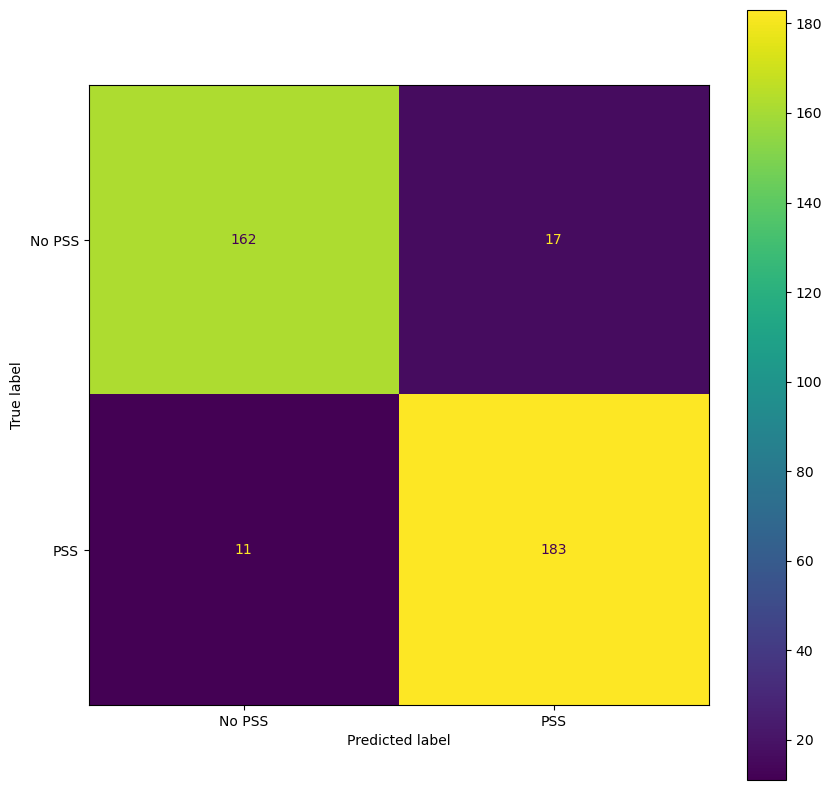

In [56]:
# plot confusion matrix

cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No PSS',"PSS"])
cm_fig.plot()
plt.savefig("../reports/figures/confusion_matrix_PSS.png", dpi=100)
plt.show()


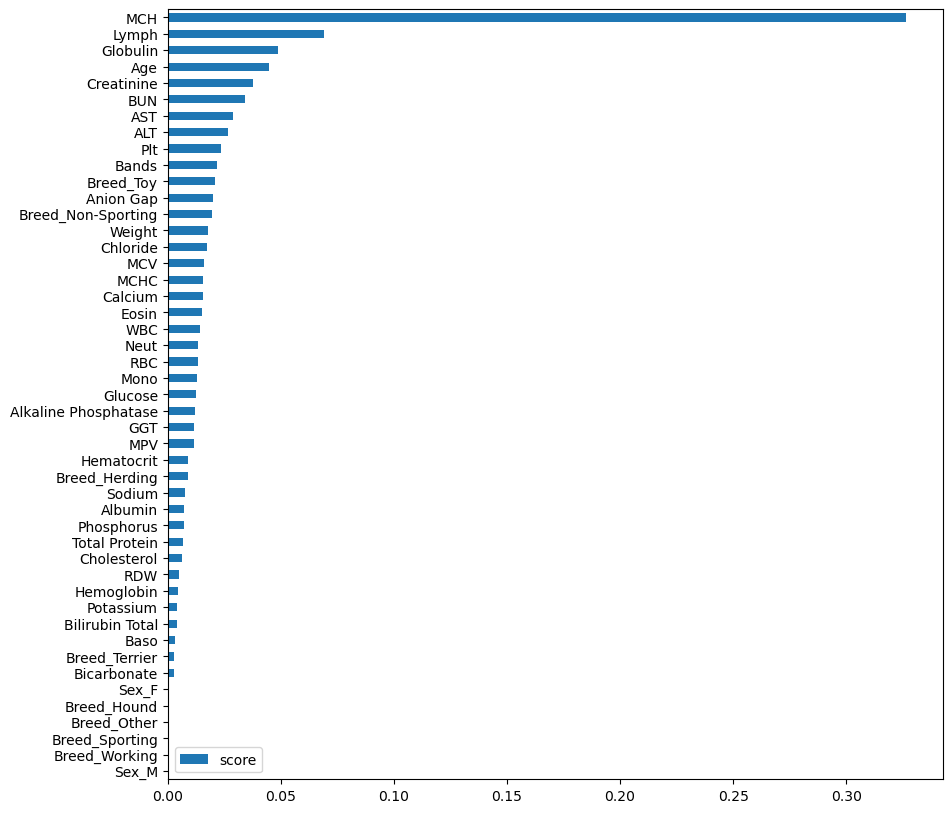

In [29]:
# plot feature importances_


plt.rcParams['figure.figsize'] = [10, 10]
pd.DataFrame(xgb.feature_importances_,columns=['score'],index = xgb.get_booster().feature_names)\
        .sort_values('score',ascending=True).plot(kind='barh') 

plt.savefig("../reports/figures/pss_feature_importances.png")

### XGBoost Model Evaluation with Scaled Data

In [4]:
#Load the model
xgb_scaled = pickle.load(open('../trained_models/pss_model_scaled.pkl', 'rb'))


# Generate predictions
predictions = xgb_scaled.predict_proba(X_test_scaled)
y_pred = xgb_scaled.predict(X_test_scaled)

# Calculate False Positive Rate, and True Positive Rate with thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
# Calculate the Area Under the ROC Curve (AUC)
auc = roc_auc_score(y_test, predictions[:,1])

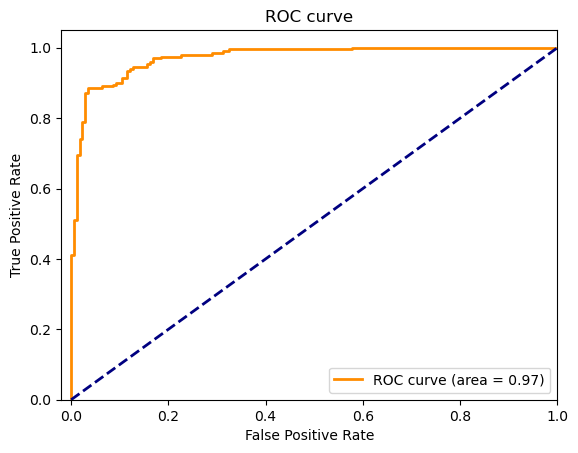

In [8]:
# Plot Area Under the ROC Curve (AUC)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig("../reports/figures/roc_auc_pss_scaled.png", dpi=100)
plt.show()



In [6]:
# Print classification report

print(classification_report(y_pred, y_test))
cm = confusion_matrix(y_pred, y_test)
acc = cm.diagonal().sum()/cm.sum()
print(acc)


              precision    recall  f1-score   support

           0       0.91      0.88      0.90       179
           1       0.90      0.92      0.91       194

    accuracy                           0.90       373
   macro avg       0.90      0.90      0.90       373
weighted avg       0.90      0.90      0.90       373

0.903485254691689


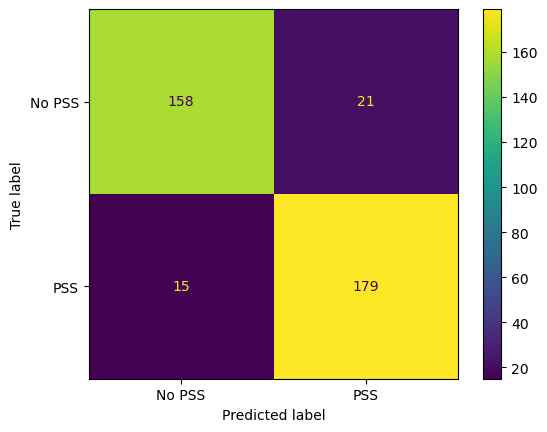

In [7]:
# plot confusion matrix

cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No PSS',"PSS"])
cm_fig.plot()
plt.savefig("../reports/figures/confusion_matrix_PSS_scaled.png", dpi=100)
plt.show()


## Subcat MLM

In [15]:
test = pd.read_csv( "../data/processed/subcat_test.csv",  index_col=0)

y_test_multi = test['Shunt_type']
X_test_multi = test.drop(['Shunt_type'], axis=1)

In [16]:
xgb_multi = pickle.load(open('../trained_models/subcat_model.pkl', 'rb'))


[21:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [17]:
predictions_multi = xgb_multi.predict_proba(X_test_multi)
y_pred_multi = xgb_multi.predict(X_test_multi)

In [18]:
def get_all_roc_coordinates(y_real, y_proba):

    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def calculate_tpr_fpr(y_real, y_pred):

    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    tpr =  TP/(TP + FN) 
    fpr = 1 - TN/(TN+FP)
    
    return tpr, fpr
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):

    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

### Subtype mapping

- 'Acquired shunt': 0,
- 'extrahepatic': 1, 
- 'intrahepatic': 2,
- 'No shunt': 3,


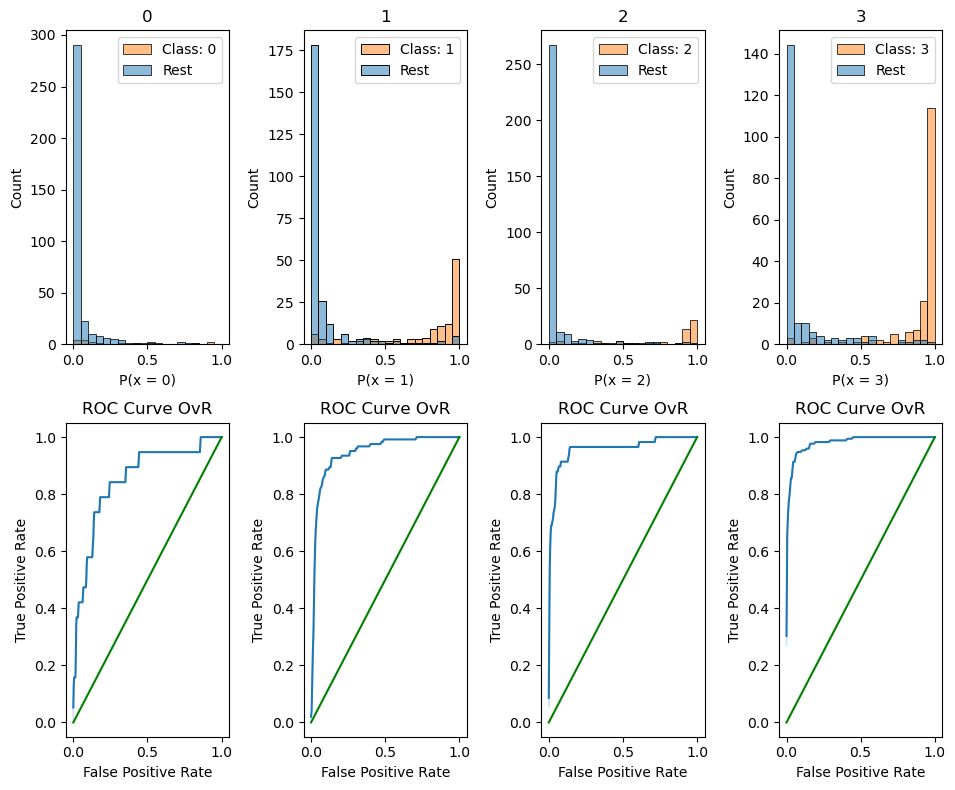

In [28]:
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = xgb_multi.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    
    c = classes[i]
    
    df_aux = X_test_multi.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test_multi]
    df_aux['prob'] = predictions_multi[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    ax = plt.subplot(2, 5, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    ax_bottom = plt.subplot(2, 5, i+6)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    plt.tight_layout()

plt.savefig("../reports/figures/roc_auc_subtypes.png")

In [58]:
print(classification_report(y_pred_multi, y_test_multi))
cm = confusion_matrix(y_pred_multi, y_test_multi)
acc = cm.diagonal().sum()/cm.sum()
print(acc)
print(cm)
    


              precision    recall  f1-score   support

           0       0.37      0.54      0.44        13
           1       0.84      0.85      0.84       121
           2       0.79      0.79      0.79        58
           3       0.95      0.91      0.93       181

    accuracy                           0.86       373
   macro avg       0.74      0.77      0.75       373
weighted avg       0.87      0.86      0.86       373

0.8579088471849866
[[  7   2   2   2]
 [  6 103   9   3]
 [  0   8  46   4]
 [  6  10   1 164]]


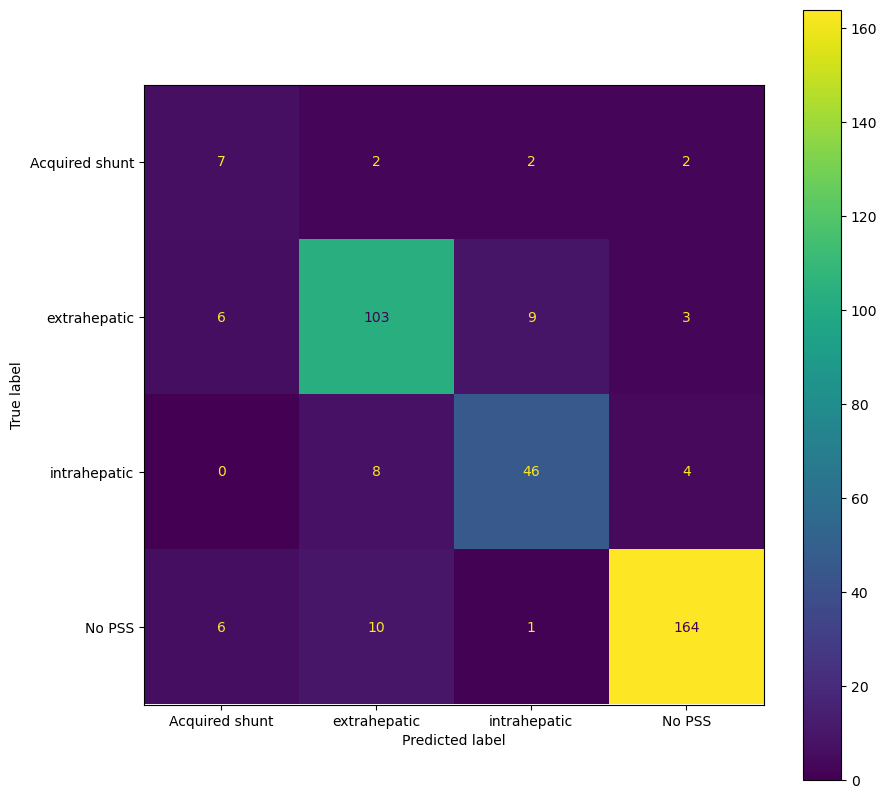

In [62]:
cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Acquired shunt','extrahepatic','intrahepatic','No PSS'])
cm_fig.plot()
plt.savefig("../reports/figures/confusion_matrix_subcat.png", dpi=100)
plt.show()

<Axes: >

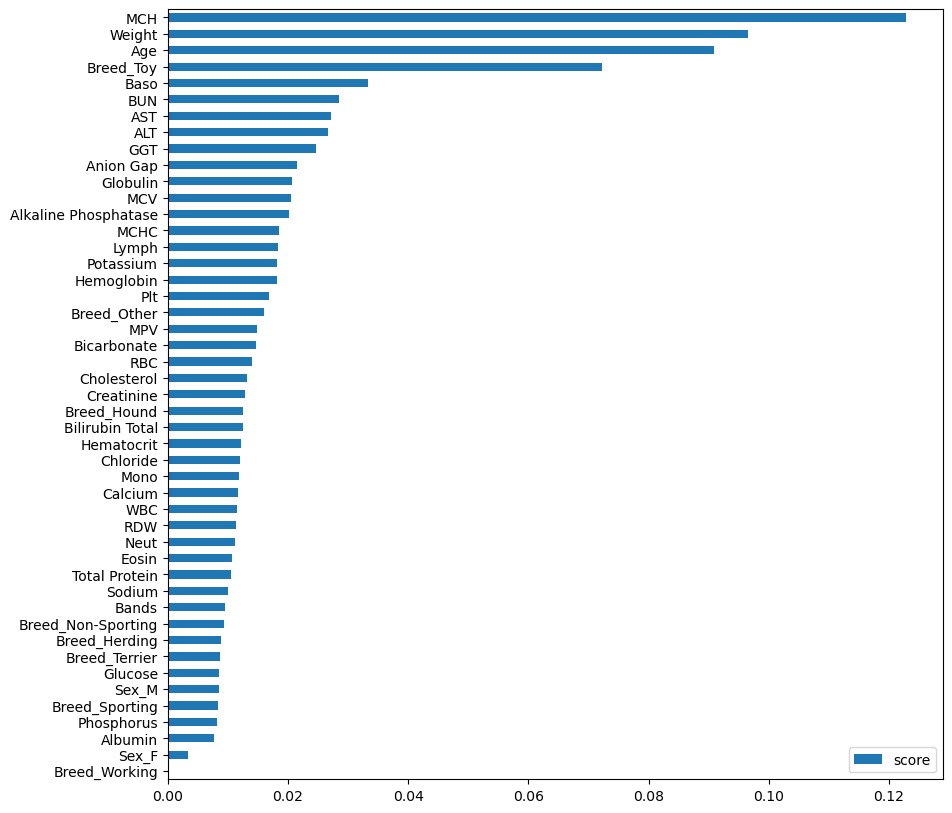

In [27]:
plt.rcParams['figure.figsize'] = [10, 10]
pd.DataFrame(xgb_multi.feature_importances_,columns=['score'],index = xgb_multi.get_booster().feature_names)\
        .sort_values('score',ascending=True).plot(kind='barh') 